# I will use the following notebook to demonstrate different steps in preprocessing

## These steps will include:

### 1) Slice timing correction
### 2) Motion correction

In [5]:
import os
from glob import glob

# Import new things that we'll need
import pandas as pd
import numpy as np
import nipype.interfaces.afni as afni
import nipype.interfaces.fsl as fsl
import nipype.interfaces.freesurfer as fs
from nipype.interfaces.utility import Function
import seaborn as sns
import nibabel as nb
import json
import nipype.interfaces.io as nio
import nipype.pipeline.engine as pe 
import matplotlib.pyplot as plt

### I next want to get a list of all of my functional files

In [6]:
sid = ['021']
base_dir = '/home/sjsuss626/Mattfeld_PSB6351/'
work_dir = '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/'
func_dir = os.path.join(base_dir, f'dset/sub-{sid[0]}/func')
fmap_dir = os.path.join(base_dir, f'dset/sub-{sid[0]}/fmap')
fs_dir = os.path.join(base_dir, 'derivatives', 'freesurfer')

# Get a list of my study task json and nifti converted files
func_json = sorted(glob(func_dir + '/*.json'))
func_files = sorted(glob(func_dir + '/*.nii.gz'))
fmap_files = sorted(glob(fmap_dir + '/*func*.nii.gz'))

In [7]:
import os
print(os.environ['PATH'])

/bin:/home/sjsuss626/.local/bin:/home/sjsuss626/fsl/share/fsl/bin:/home/sjsuss626/fsl/share/fsl/bin:/home/sjsuss626/.local/bin:/usr/bin:/home/sjsuss626/anaconda3/condabin:/usr/local/freesurfer/bin:/usr/local/freesurfer/fsfast/bin:/usr/local/freesurfer/tktools:/home/sjsuss626/fsl/bin:/home/sjsuss626/fsl/share/fsl/bin:/usr/local/freesurfer/mni/bin:/home/sjsuss626/fsl/bin:/home/sjsuss626/fsl/share/fsl/bin:/home/sjsuss626/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:home/<user>/.local/bin:/snap/bin:.:.:/home/sjsuss626/abin:/home/sjsuss626/fsl/share/fsl/bin:/home/sjsuss626/fsl/share/fsl/bin:/home/sjsuss626/.local/bin:/usr/bin:/home/sjsuss626/anaconda3/condabin:/usr/local/freesurfer/bin:/usr/local/freesurfer/fsfast/bin:/usr/local/freesurfer/tktools:/home/sjsuss626/fsl/bin:/home/sjsuss626/fsl/share/fsl/bin:/usr/local/freesurfer/mni/bin:/home/sjsuss626/fsl/bin:/home/sjsuss626/fsl/share/fsl/bin:/home/sjsuss626/.local/bin:/usr/loca

In [8]:
func_files

['/home/sjsuss626/Mattfeld_PSB6351/dset/sub-021/func/sub-021_task-loc_run-1_bold.nii.gz',
 '/home/sjsuss626/Mattfeld_PSB6351/dset/sub-021/func/sub-021_task-loc_run-2_bold.nii.gz',
 '/home/sjsuss626/Mattfeld_PSB6351/dset/sub-021/func/sub-021_task-study_run-1_bold.nii.gz',
 '/home/sjsuss626/Mattfeld_PSB6351/dset/sub-021/func/sub-021_task-study_run-2_bold.nii.gz',
 '/home/sjsuss626/Mattfeld_PSB6351/dset/sub-021/func/sub-021_task-study_run-3_bold.nii.gz',
 '/home/sjsuss626/Mattfeld_PSB6351/dset/sub-021/func/sub-021_task-study_run-4_bold.nii.gz']

### Next I want to build and run function to perform slice timing correction. I'm going to have to extract some important information from the .json files like the multiband slicetiming.

In [14]:
# Here I am building a function that eliminates the
# mapnode directory structure and assists in saving
# all of the outputs into a single directory
def get_subs(func_files):
    '''Produces Name Substitutions for Each Contrast in FSL'''
    subs = []
    for curr_run in range(len(func_files)):
        # Substitute MCFLIRT outputs, if necessary
        subs.append(('_mcf%d' % curr_run, ''))
        subs.append(('_mean_reg%d' % curr_run, ''))
        subs.append(('_slicetimer%d' % curr_run, ''))
        
    return subs

# Here I am building a function that takes in a
# text file that includes the number of outliers
# at each volume and then finds which volume (e.g., index)
# has the minimum number of outliers (e.g., min) 
# searching over the first 201 volumes
# If the index function returns a list because there were
# multiple volumes with the same outlier count, pick the first one

#window=200 #attempt 100, 200, and 400

# HW3 - change the search window. how does this impact your results?
# Function that takes window as an argument
#def best_vol(outlier_count):
    # best_vol_num = outlier_count.index(min(outlier_count[:100]))
#    best_vol_num = outlier_count.index(min(outlier_count[:200]))
    # best_vol_num = outlier_count.index(min(outlier_count[:400])    
#    if isinstance(best_vol_num, list):
#        best_vol_num = best_vol_num[0]
#    return best_vol_num

# Here I am creating a list of lists containing the slice timing for each study run
####################################
# HW3 - what column do you query to extract the appropriate information?
####################################e
slice_timing_list = []
for curr_json in func_json:
    curr_json_data = open(curr_json)
    curr_func_metadata = json.load(curr_json_data)
    slice_timing_list.append(curr_func_metadata['SliceTiming'])

# Here I am establishing a nipype work flow that I will eventually execute
psb6351_wf = pe.Workflow(name='psb6351_wf_fsl_200')
psb6351_wf.base_dir = work_dir + f'/psb6351workdir/sub-{sid[0]}'
psb6351_wf.config['execution']['use_relative_paths'] = True

# Create a Function node to substitute names of files created during pipeline
getsubs = pe.Node(Function(input_names=['func_files'],
                           output_names=['subs'],
                           function=get_subs),
                  name='getsubs')
getsubs.inputs.func_files = func_files

# Here I am inputing just the first run functional data
# I want to use afni's 3dToutcount to find the number of 
# outliers at each volume.  I will use this information to
# later select the earliest volume with the least number of outliers
# to serve as the base for the motion correction
# id_outliers = pe.Node(afni.OutlierCount(),
#                      name = 'id_outliers')
####################################
# HW3 - what happens if you chose a different func_file?  How does it impact results
# Is the first func file the best way to go?
####################################
# id_outliers.inputs.in_file = func_files[0]
# id_outliers.inputs.automask = True
# id_outliers.inputs.out_file = 'outlier_file'

# Create a Function node to identify the best volume based
# on the number of outliers at each volume. I'm searching
# for the index in the first 201 volumes that has the 
# minimum number of outliers and will use the min() function
# I will use the index function to get the best vol. 
# getbestvol = pe.Node(Function(input_names=['outlier_count'],
#                              output_names=['best_vol_num'],
#                              function=best_vol),
#                     name='getbestvol')
# psb6351_wf.connect(id_outliers, 'out_file', getbestvol, 'outlier_count')

# Extract the earliest volume with the
# the fewest outliers of the first run as the reference 
#extractref = pe.Node(fsl.ExtractROI(t_size=1),
#                     name = "extractref")

####################################
#extractref.inputs.in_file = func_files[0]
#psb6351_wf.connect(getbestvol, 'best_vol_num', extractref, 't_min')

# FSL Motion Correction (MCFLIRT)
mcflirt_fsl = pe.MapNode(fsl.MCFLIRT(), 
                         iterfield=['in_file'], 
                         name='mcflirt_fsl')
mcflirt_fsl.inputs.cost = 'normcorr'   
mcflirt_fsl.inputs.mean_vol = True     
mcflirt_fsl.inputs.save_plots = True   
mcflirt_fsl.inputs.in_file = func_files

psb6351_wf.connect(?, '', mcflirt_fsl, 'out_file')

# FSL Slice Timing Correction (SliceTimer)
slicetimer_fsl = pe.MapNode(fsl.SliceTimer(), 
                            iterfield=['in_file', 'slice_timing'],  
                            name='slicetimer_fsl')
slicetimer_fsl.inputs.time_repetition = 1.76        
slicetimer_fsl.inputs.slice_direction = 2  # for the j direction ?
slicetimer_fsl.inputs.multiband_factor = 3
#slicetimer_fsl.inputs.custom_order = slice_timing_list  #to get slice timing? 

# Connect MCFLIRT output to SliceTimer input
psb6351_wf.connect(mcflirt_fsl, 'out_file', slicetimer_fsl, 'in_file')

# DataSink for saving the results
datasink_fsl = pe.Node(nio.DataSink(), name="datasink_fsl")
datasink_fsl.inputs.base_directory = os.path.join(base_dir, f'derivatives/preproc_motion_first_fsl_200')
datasink_fsl.inputs.container = f'sub-{sid[0]}'

# Connect outputs to DataSink
psb6351_wf.connect(slicetimer_fsl, 'slice_time_corrected_file', datasink_fsl, 'sltime_corr')
psb6351_wf.connect(mcflirt_fsl, 'out_file', datasink_fsl, 'motion.@corrfile')
psb6351_wf.connect(mcflirt_fsl, 'par_file', datasink_fsl, 'motion.@par')
psb6351_wf.connect(mcflirt_fsl, 'mat_file', datasink_fsl, 'motion.@matrix')
psb6351_wf.connect(getsubs, 'subs', datasink_fsl, 'substitutions')

# Run the workflow
psb6351_wf.run()


241014-12:36:55,975 nipype.workflow INFO:
	 Workflow psb6351_wf_fsl_200 settings: ['check', 'execution', 'logging', 'monitoring']
241014-12:36:55,977 nipype.workflow INFO:
	 Running serially.
241014-12:36:55,980 nipype.workflow INFO:
	 [Node] Setting-up "_mcflirt_fsl0" in "/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl0".
241014-12:36:55,999 nipype.workflow INFO:
	 [Node] Executing "_mcflirt_fsl0" <nipype.interfaces.fsl.preprocess.MCFLIRT>
241014-12:38:06,761 nipype.workflow INFO:
	 [Node] Finished "_mcflirt_fsl0", elapsed time 70.760797s.
241014-12:38:06,761 nipype.workflow WARNING:
	 Storing result file without outputs
241014-12:38:06,762 nipype.workflow WARNING:
	 [Node] Error on "_mcflirt_fsl0" (/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl0)
241014-12:38:06,763 nipype.workflow INFO:
	 [Node] Setting-up "_mcflirt_

NodeExecutionError: Subnodes of node: mcflirt_fsl failed:
Subnode 0 failed
Error: Traceback (most recent call last):
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 453, in aggregate_outputs
    setattr(outputs, key, val)
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 330, in validate
    value = super(File, self).validate(objekt, name, value, return_pathlike=True)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 135, in validate
    self.error(objekt, name, str(value))
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/traits/base_trait_handler.py", line 74, in error
    raise TraitError(
traits.trait_errors.TraitError: The 'mean_img' trait of a MCFLIRTOutputSpec instance must be a pathlike object or string representing an existing file, but a value of '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl0/sub-021_task-loc_run-1_bold_mcf_mean_reg.nii.gz' <class 'str'> was specified.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 400, in run
    outputs = self.aggregate_outputs(runtime)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 460, in aggregate_outputs
    raise FileNotFoundError(msg)
FileNotFoundError: No such file or directory '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl0/sub-021_task-loc_run-1_bold_mcf_mean_reg.nii.gz' for output 'mean_img' of a MCFLIRT interface

Traceback (most recent call last):

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/utils.py", line 94, in nodelist_runner
    result = node.run(updatehash=updatehash)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 527, in run
    result = self._run_interface(execute=True)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 645, in _run_interface
    return self._run_command(execute)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 771, in _run_command
    raise NodeExecutionError(msg)

nipype.pipeline.engine.nodes.NodeExecutionError: Exception raised while executing Node _mcflirt_fsl0.

Cmdline:
	mcflirt -in /home/sjsuss626/Mattfeld_PSB6351/dset/sub-021/func/sub-021_task-loc_run-1_bold.nii.gz -cost normcorr -meanvol -out /home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl0/sub-021_task-loc_run-1_bold_mcf.nii.gz -plots
Stdout:

Stderr:

Traceback:
	Traceback (most recent call last):
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 453, in aggregate_outputs
	    setattr(outputs, key, val)
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 330, in validate
	    value = super(File, self).validate(objekt, name, value, return_pathlike=True)
	            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 135, in validate
	    self.error(objekt, name, str(value))
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/traits/base_trait_handler.py", line 74, in error
	    raise TraitError(
	traits.trait_errors.TraitError: The 'mean_img' trait of a MCFLIRTOutputSpec instance must be a pathlike object or string representing an existing file, but a value of '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl0/sub-021_task-loc_run-1_bold_mcf_mean_reg.nii.gz' <class 'str'> was specified.

	During handling of the above exception, another exception occurred:

	Traceback (most recent call last):
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 400, in run
	    outputs = self.aggregate_outputs(runtime)
	              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 460, in aggregate_outputs
	    raise FileNotFoundError(msg)
	FileNotFoundError: No such file or directory '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl0/sub-021_task-loc_run-1_bold_mcf_mean_reg.nii.gz' for output 'mean_img' of a MCFLIRT interface


Subnode 1 failed
Error: Traceback (most recent call last):
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 453, in aggregate_outputs
    setattr(outputs, key, val)
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 330, in validate
    value = super(File, self).validate(objekt, name, value, return_pathlike=True)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 135, in validate
    self.error(objekt, name, str(value))
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/traits/base_trait_handler.py", line 74, in error
    raise TraitError(
traits.trait_errors.TraitError: The 'mean_img' trait of a MCFLIRTOutputSpec instance must be a pathlike object or string representing an existing file, but a value of '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl1/sub-021_task-loc_run-2_bold_mcf_mean_reg.nii.gz' <class 'str'> was specified.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 400, in run
    outputs = self.aggregate_outputs(runtime)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 460, in aggregate_outputs
    raise FileNotFoundError(msg)
FileNotFoundError: No such file or directory '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl1/sub-021_task-loc_run-2_bold_mcf_mean_reg.nii.gz' for output 'mean_img' of a MCFLIRT interface

Traceback (most recent call last):

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/utils.py", line 94, in nodelist_runner
    result = node.run(updatehash=updatehash)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 527, in run
    result = self._run_interface(execute=True)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 645, in _run_interface
    return self._run_command(execute)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 771, in _run_command
    raise NodeExecutionError(msg)

nipype.pipeline.engine.nodes.NodeExecutionError: Exception raised while executing Node _mcflirt_fsl1.

Cmdline:
	mcflirt -in /home/sjsuss626/Mattfeld_PSB6351/dset/sub-021/func/sub-021_task-loc_run-2_bold.nii.gz -cost normcorr -meanvol -out /home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl1/sub-021_task-loc_run-2_bold_mcf.nii.gz -plots
Stdout:

Stderr:

Traceback:
	Traceback (most recent call last):
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 453, in aggregate_outputs
	    setattr(outputs, key, val)
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 330, in validate
	    value = super(File, self).validate(objekt, name, value, return_pathlike=True)
	            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 135, in validate
	    self.error(objekt, name, str(value))
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/traits/base_trait_handler.py", line 74, in error
	    raise TraitError(
	traits.trait_errors.TraitError: The 'mean_img' trait of a MCFLIRTOutputSpec instance must be a pathlike object or string representing an existing file, but a value of '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl1/sub-021_task-loc_run-2_bold_mcf_mean_reg.nii.gz' <class 'str'> was specified.

	During handling of the above exception, another exception occurred:

	Traceback (most recent call last):
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 400, in run
	    outputs = self.aggregate_outputs(runtime)
	              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 460, in aggregate_outputs
	    raise FileNotFoundError(msg)
	FileNotFoundError: No such file or directory '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl1/sub-021_task-loc_run-2_bold_mcf_mean_reg.nii.gz' for output 'mean_img' of a MCFLIRT interface


Subnode 2 failed
Error: Traceback (most recent call last):
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 453, in aggregate_outputs
    setattr(outputs, key, val)
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 330, in validate
    value = super(File, self).validate(objekt, name, value, return_pathlike=True)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 135, in validate
    self.error(objekt, name, str(value))
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/traits/base_trait_handler.py", line 74, in error
    raise TraitError(
traits.trait_errors.TraitError: The 'mean_img' trait of a MCFLIRTOutputSpec instance must be a pathlike object or string representing an existing file, but a value of '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl2/sub-021_task-study_run-1_bold_mcf_mean_reg.nii.gz' <class 'str'> was specified.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 400, in run
    outputs = self.aggregate_outputs(runtime)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 460, in aggregate_outputs
    raise FileNotFoundError(msg)
FileNotFoundError: No such file or directory '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl2/sub-021_task-study_run-1_bold_mcf_mean_reg.nii.gz' for output 'mean_img' of a MCFLIRT interface

Traceback (most recent call last):

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/utils.py", line 94, in nodelist_runner
    result = node.run(updatehash=updatehash)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 527, in run
    result = self._run_interface(execute=True)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 645, in _run_interface
    return self._run_command(execute)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 771, in _run_command
    raise NodeExecutionError(msg)

nipype.pipeline.engine.nodes.NodeExecutionError: Exception raised while executing Node _mcflirt_fsl2.

Cmdline:
	mcflirt -in /home/sjsuss626/Mattfeld_PSB6351/dset/sub-021/func/sub-021_task-study_run-1_bold.nii.gz -cost normcorr -meanvol -out /home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl2/sub-021_task-study_run-1_bold_mcf.nii.gz -plots
Stdout:

Stderr:

Traceback:
	Traceback (most recent call last):
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 453, in aggregate_outputs
	    setattr(outputs, key, val)
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 330, in validate
	    value = super(File, self).validate(objekt, name, value, return_pathlike=True)
	            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 135, in validate
	    self.error(objekt, name, str(value))
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/traits/base_trait_handler.py", line 74, in error
	    raise TraitError(
	traits.trait_errors.TraitError: The 'mean_img' trait of a MCFLIRTOutputSpec instance must be a pathlike object or string representing an existing file, but a value of '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl2/sub-021_task-study_run-1_bold_mcf_mean_reg.nii.gz' <class 'str'> was specified.

	During handling of the above exception, another exception occurred:

	Traceback (most recent call last):
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 400, in run
	    outputs = self.aggregate_outputs(runtime)
	              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 460, in aggregate_outputs
	    raise FileNotFoundError(msg)
	FileNotFoundError: No such file or directory '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl2/sub-021_task-study_run-1_bold_mcf_mean_reg.nii.gz' for output 'mean_img' of a MCFLIRT interface


Subnode 3 failed
Error: Traceback (most recent call last):
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 453, in aggregate_outputs
    setattr(outputs, key, val)
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 330, in validate
    value = super(File, self).validate(objekt, name, value, return_pathlike=True)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 135, in validate
    self.error(objekt, name, str(value))
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/traits/base_trait_handler.py", line 74, in error
    raise TraitError(
traits.trait_errors.TraitError: The 'mean_img' trait of a MCFLIRTOutputSpec instance must be a pathlike object or string representing an existing file, but a value of '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl3/sub-021_task-study_run-2_bold_mcf_mean_reg.nii.gz' <class 'str'> was specified.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 400, in run
    outputs = self.aggregate_outputs(runtime)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 460, in aggregate_outputs
    raise FileNotFoundError(msg)
FileNotFoundError: No such file or directory '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl3/sub-021_task-study_run-2_bold_mcf_mean_reg.nii.gz' for output 'mean_img' of a MCFLIRT interface

Traceback (most recent call last):

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/utils.py", line 94, in nodelist_runner
    result = node.run(updatehash=updatehash)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 527, in run
    result = self._run_interface(execute=True)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 645, in _run_interface
    return self._run_command(execute)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 771, in _run_command
    raise NodeExecutionError(msg)

nipype.pipeline.engine.nodes.NodeExecutionError: Exception raised while executing Node _mcflirt_fsl3.

Cmdline:
	mcflirt -in /home/sjsuss626/Mattfeld_PSB6351/dset/sub-021/func/sub-021_task-study_run-2_bold.nii.gz -cost normcorr -meanvol -out /home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl3/sub-021_task-study_run-2_bold_mcf.nii.gz -plots
Stdout:

Stderr:

Traceback:
	Traceback (most recent call last):
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 453, in aggregate_outputs
	    setattr(outputs, key, val)
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 330, in validate
	    value = super(File, self).validate(objekt, name, value, return_pathlike=True)
	            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 135, in validate
	    self.error(objekt, name, str(value))
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/traits/base_trait_handler.py", line 74, in error
	    raise TraitError(
	traits.trait_errors.TraitError: The 'mean_img' trait of a MCFLIRTOutputSpec instance must be a pathlike object or string representing an existing file, but a value of '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl3/sub-021_task-study_run-2_bold_mcf_mean_reg.nii.gz' <class 'str'> was specified.

	During handling of the above exception, another exception occurred:

	Traceback (most recent call last):
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 400, in run
	    outputs = self.aggregate_outputs(runtime)
	              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 460, in aggregate_outputs
	    raise FileNotFoundError(msg)
	FileNotFoundError: No such file or directory '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl3/sub-021_task-study_run-2_bold_mcf_mean_reg.nii.gz' for output 'mean_img' of a MCFLIRT interface


Subnode 4 failed
Error: Traceback (most recent call last):
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 453, in aggregate_outputs
    setattr(outputs, key, val)
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 330, in validate
    value = super(File, self).validate(objekt, name, value, return_pathlike=True)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 135, in validate
    self.error(objekt, name, str(value))
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/traits/base_trait_handler.py", line 74, in error
    raise TraitError(
traits.trait_errors.TraitError: The 'mean_img' trait of a MCFLIRTOutputSpec instance must be a pathlike object or string representing an existing file, but a value of '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl4/sub-021_task-study_run-3_bold_mcf_mean_reg.nii.gz' <class 'str'> was specified.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 400, in run
    outputs = self.aggregate_outputs(runtime)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 460, in aggregate_outputs
    raise FileNotFoundError(msg)
FileNotFoundError: No such file or directory '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl4/sub-021_task-study_run-3_bold_mcf_mean_reg.nii.gz' for output 'mean_img' of a MCFLIRT interface

Traceback (most recent call last):

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/utils.py", line 94, in nodelist_runner
    result = node.run(updatehash=updatehash)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 527, in run
    result = self._run_interface(execute=True)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 645, in _run_interface
    return self._run_command(execute)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 771, in _run_command
    raise NodeExecutionError(msg)

nipype.pipeline.engine.nodes.NodeExecutionError: Exception raised while executing Node _mcflirt_fsl4.

Cmdline:
	mcflirt -in /home/sjsuss626/Mattfeld_PSB6351/dset/sub-021/func/sub-021_task-study_run-3_bold.nii.gz -cost normcorr -meanvol -out /home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl4/sub-021_task-study_run-3_bold_mcf.nii.gz -plots
Stdout:

Stderr:

Traceback:
	Traceback (most recent call last):
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 453, in aggregate_outputs
	    setattr(outputs, key, val)
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 330, in validate
	    value = super(File, self).validate(objekt, name, value, return_pathlike=True)
	            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 135, in validate
	    self.error(objekt, name, str(value))
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/traits/base_trait_handler.py", line 74, in error
	    raise TraitError(
	traits.trait_errors.TraitError: The 'mean_img' trait of a MCFLIRTOutputSpec instance must be a pathlike object or string representing an existing file, but a value of '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl4/sub-021_task-study_run-3_bold_mcf_mean_reg.nii.gz' <class 'str'> was specified.

	During handling of the above exception, another exception occurred:

	Traceback (most recent call last):
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 400, in run
	    outputs = self.aggregate_outputs(runtime)
	              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 460, in aggregate_outputs
	    raise FileNotFoundError(msg)
	FileNotFoundError: No such file or directory '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl4/sub-021_task-study_run-3_bold_mcf_mean_reg.nii.gz' for output 'mean_img' of a MCFLIRT interface


Subnode 5 failed
Error: Traceback (most recent call last):
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 453, in aggregate_outputs
    setattr(outputs, key, val)
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 330, in validate
    value = super(File, self).validate(objekt, name, value, return_pathlike=True)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 135, in validate
    self.error(objekt, name, str(value))
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/traits/base_trait_handler.py", line 74, in error
    raise TraitError(
traits.trait_errors.TraitError: The 'mean_img' trait of a MCFLIRTOutputSpec instance must be a pathlike object or string representing an existing file, but a value of '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl5/sub-021_task-study_run-4_bold_mcf_mean_reg.nii.gz' <class 'str'> was specified.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 400, in run
    outputs = self.aggregate_outputs(runtime)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 460, in aggregate_outputs
    raise FileNotFoundError(msg)
FileNotFoundError: No such file or directory '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl5/sub-021_task-study_run-4_bold_mcf_mean_reg.nii.gz' for output 'mean_img' of a MCFLIRT interface

Traceback (most recent call last):

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/utils.py", line 94, in nodelist_runner
    result = node.run(updatehash=updatehash)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 527, in run
    result = self._run_interface(execute=True)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 645, in _run_interface
    return self._run_command(execute)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/pipeline/engine/nodes.py", line 771, in _run_command
    raise NodeExecutionError(msg)

nipype.pipeline.engine.nodes.NodeExecutionError: Exception raised while executing Node _mcflirt_fsl5.

Cmdline:
	mcflirt -in /home/sjsuss626/Mattfeld_PSB6351/dset/sub-021/func/sub-021_task-study_run-4_bold.nii.gz -cost normcorr -meanvol -out /home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl5/sub-021_task-study_run-4_bold_mcf.nii.gz -plots
Stdout:

Stderr:

Traceback:
	Traceback (most recent call last):
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 453, in aggregate_outputs
	    setattr(outputs, key, val)
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 330, in validate
	    value = super(File, self).validate(objekt, name, value, return_pathlike=True)
	            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/traits_extension.py", line 135, in validate
	    self.error(objekt, name, str(value))
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/traits/base_trait_handler.py", line 74, in error
	    raise TraitError(
	traits.trait_errors.TraitError: The 'mean_img' trait of a MCFLIRTOutputSpec instance must be a pathlike object or string representing an existing file, but a value of '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl5/sub-021_task-study_run-4_bold_mcf_mean_reg.nii.gz' <class 'str'> was specified.

	During handling of the above exception, another exception occurred:

	Traceback (most recent call last):
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 400, in run
	    outputs = self.aggregate_outputs(runtime)
	              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
	  File "/home/sjsuss626/.local/lib/python3.12/site-packages/nipype/interfaces/base/core.py", line 460, in aggregate_outputs
	    raise FileNotFoundError(msg)
	FileNotFoundError: No such file or directory '/home/sjsuss626/scratch/madlab/Mattfeld_PSB6351/sjuss626/psb6351workdir/sub-021/psb6351_wf_fsl_200/mcflirt_fsl/mapflow/_mcflirt_fsl5/sub-021_task-study_run-4_bold_mcf_mean_reg.nii.gz' for output 'mean_img' of a MCFLIRT interface



### Now I will load and plot the motion files

/tmp/ipykernel_298830/461431260.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


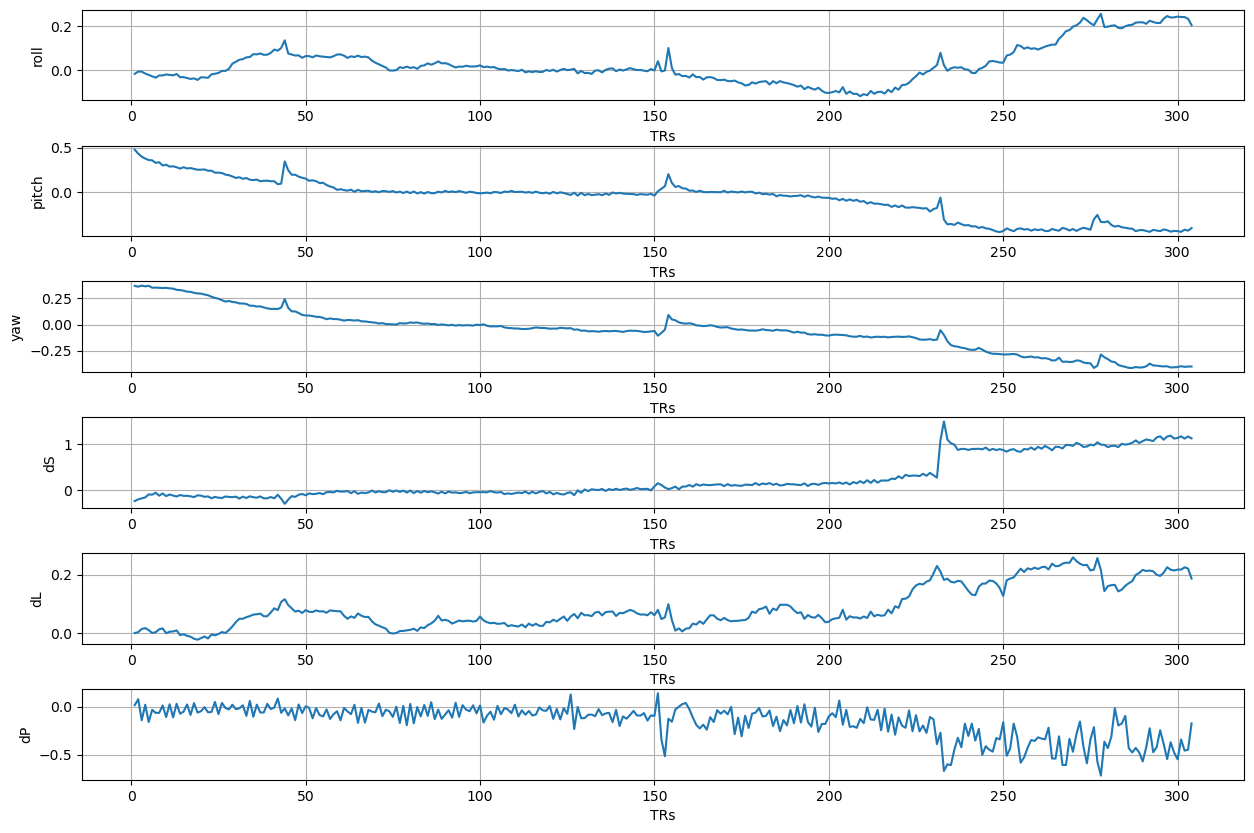

/tmp/ipykernel_298830/461431260.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


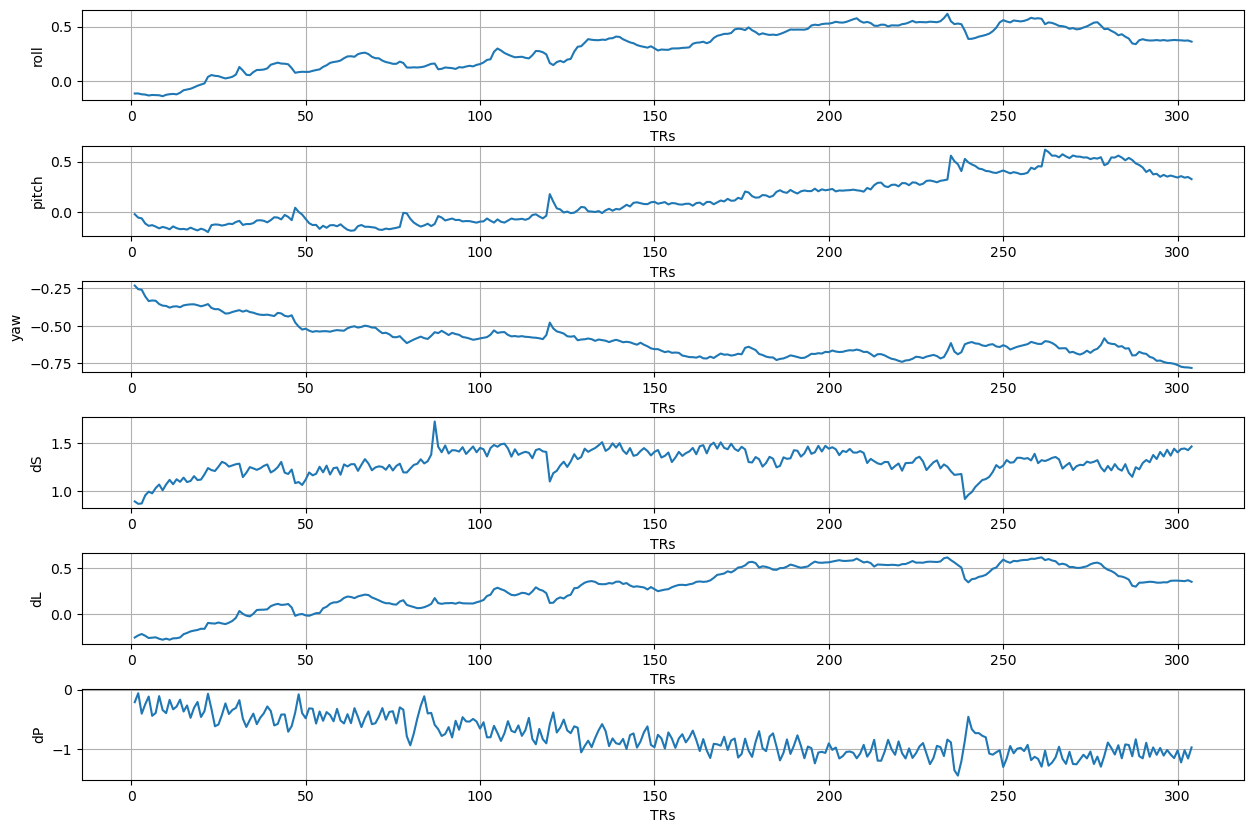

/tmp/ipykernel_298830/461431260.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


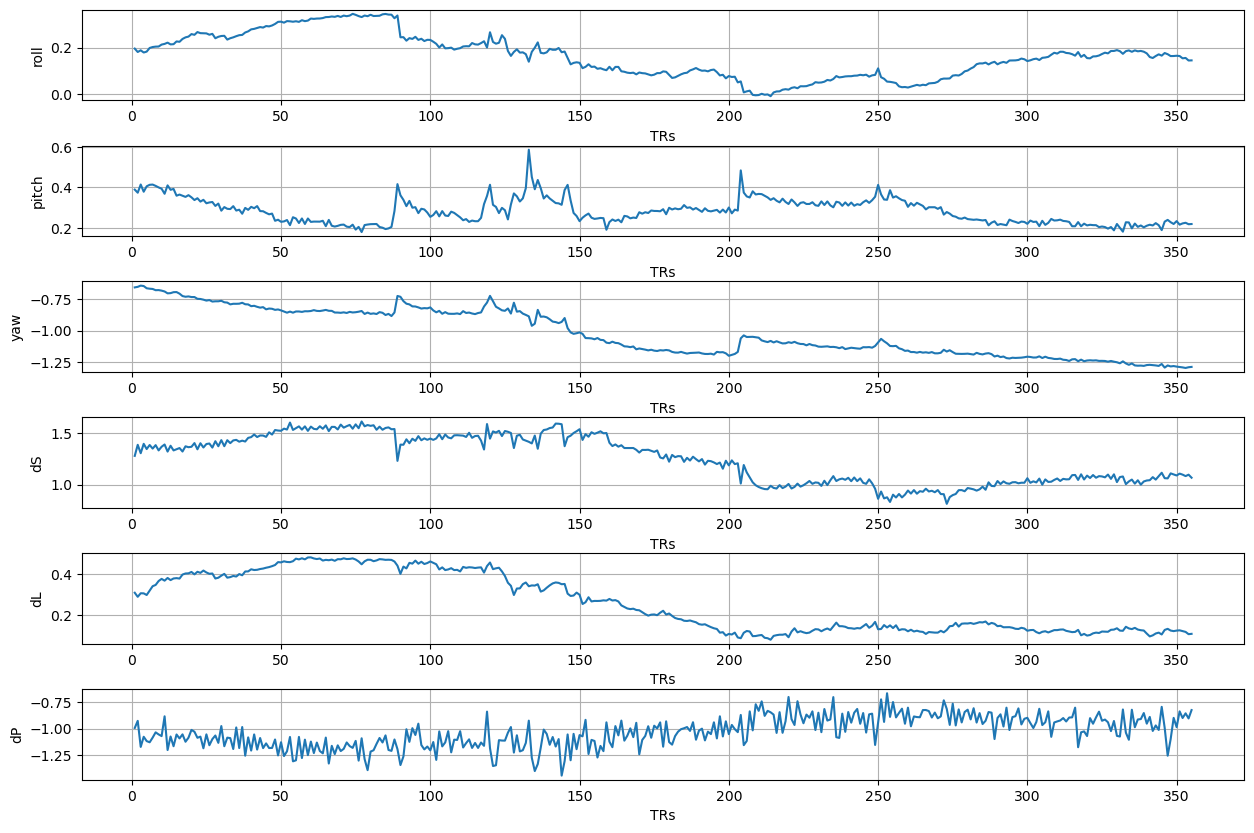

/tmp/ipykernel_298830/461431260.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


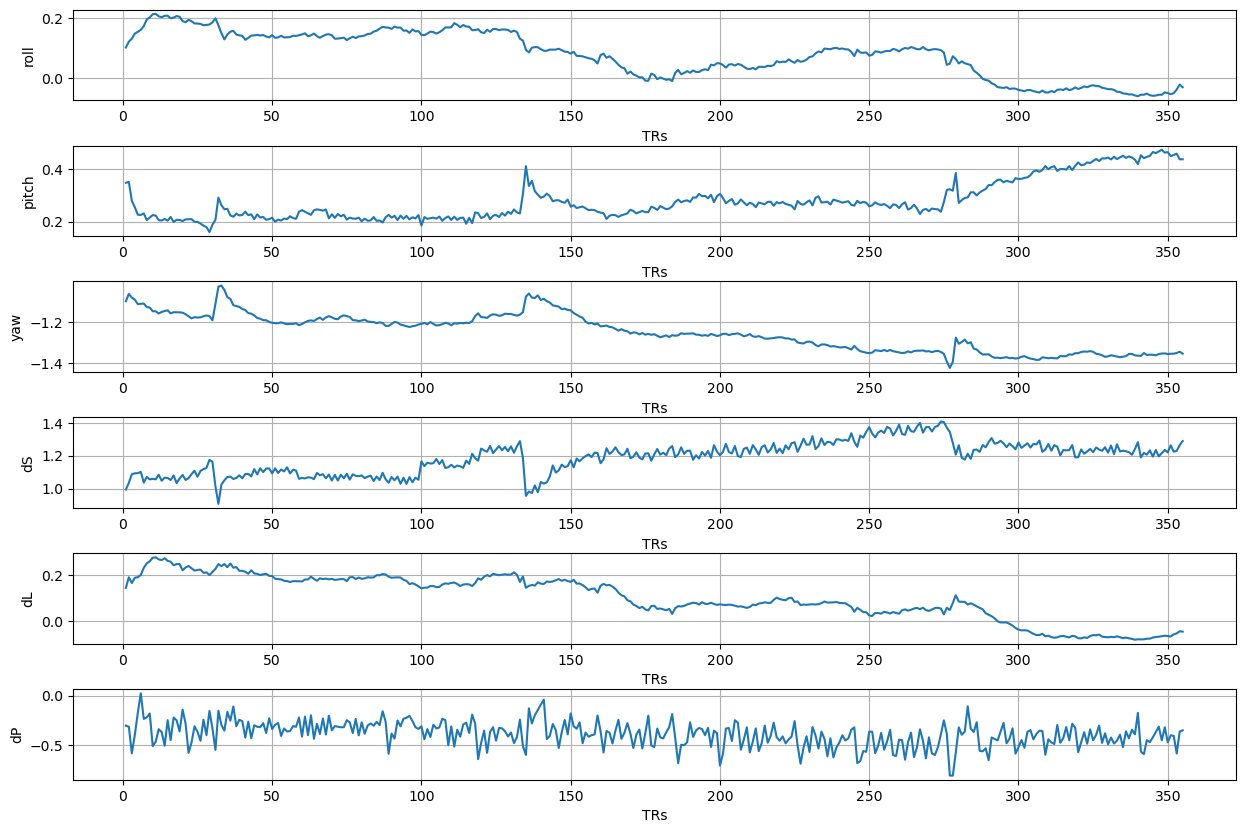

/tmp/ipykernel_298830/461431260.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


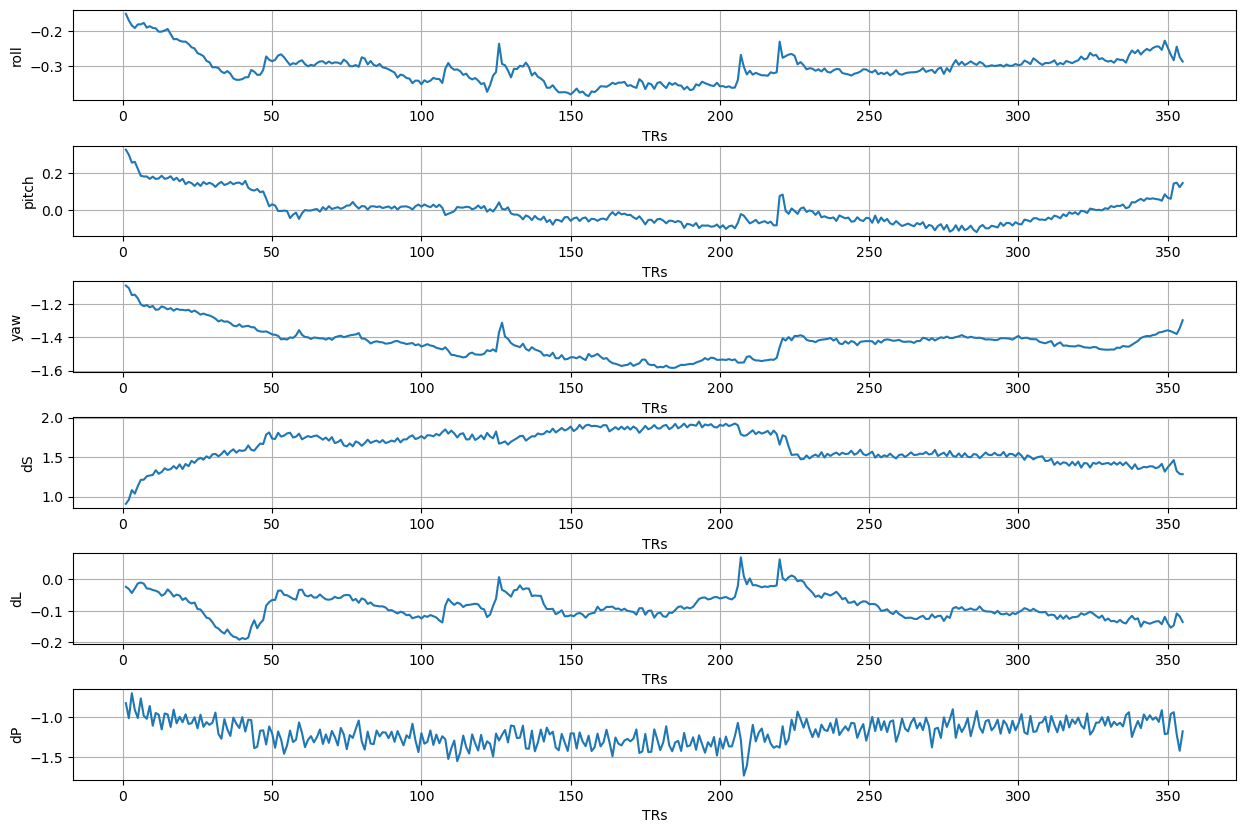

/tmp/ipykernel_298830/461431260.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)


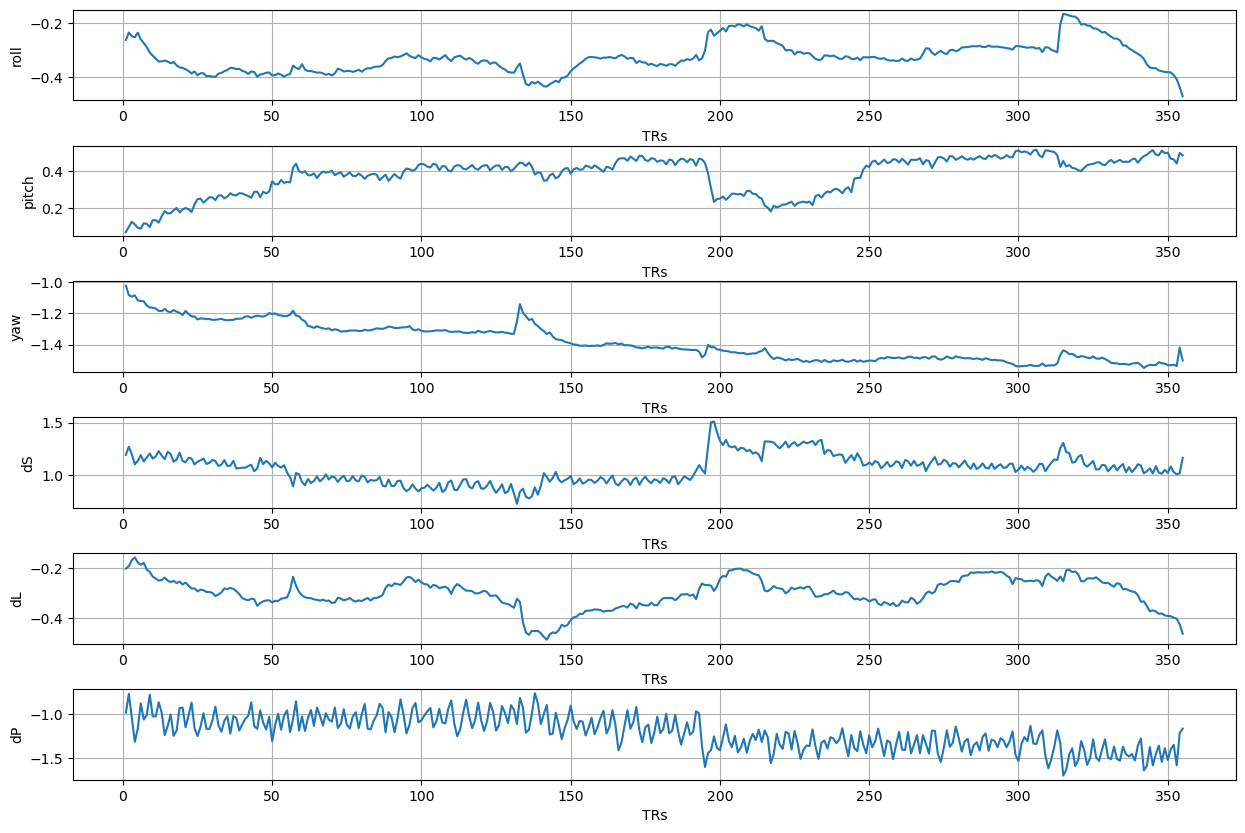

In [10]:
motion_dir = os.path.join(base_dir, f'derivatives/preproc_motion_first_fsl_200/sub-{sid[0]}/motion')
study_motion_files = sorted(glob(motion_dir + '/*_bold.1D'))

for curr_mot_file in study_motion_files:
    motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)
    motion_df.columns = ['roll', 'pitch', 'yaw', 'dS', 'dL', 'dP']


    num_vols = range(1, len(motion_df)+1)
    fig, axs = plt.subplots(motion_df.shape[1], 1, figsize = (15, 10))
    # make a little extra space between the subplots
    fig.subplots_adjust(hspace=0.5)

    for idx, curr_col in enumerate(motion_df.keys()):
        axs[idx].plot(num_vols, motion_df[f'{curr_col}'])
        axs[idx].set_xlabel('TRs')
        axs[idx].set_ylabel(f'{curr_col}')
        axs[idx].grid(True)

    plt.show()

####################################
# HW3 - compare the motion parameter plots from this script to 
# the carpet plot below.  What is the relationship between large rotations and/or translations and the carpet plot
# reference specific TRs and their relation to time.
####################################

/tmp/ipykernel_296856/2203910218.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  display.show()


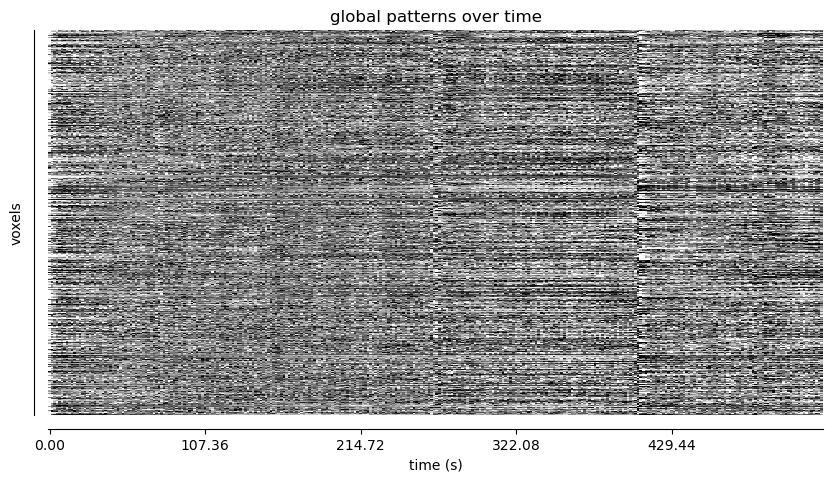

In [7]:
from nilearn.plotting import plot_carpet

from nilearn import masking

# Build an EPI-based mask because we have no anatomical data

####################################
# HW3 - compare different func files and their carpet plots
# which one are we looking at here? Which func file has the 
# most visually striking motion related changes in voxel intensity?
####################################

mask_img = masking.compute_epi_mask(func_files[0])

display = plot_carpet(
    func_files[0],
    mask_img,
    t_r=1.76,
    standardize="zscore_sample",
    title="global patterns over time",
)

display.show()

RUNNING MOTION CORRECTION BEFORE SLICETIME CORRECTION

In [ ]:
#pending

Now look at motion plots with order reversed

In [ ]:
motion_dir = os.path.join(base_dir, f'derivatives/preproc_slicetiming_first_fsl_200/sub-{sid[0]}/motion')
study_motion_files = sorted(glob(motion_dir + '/*_bold.1D'))

for curr_mot_file in study_motion_files:
    motion_df = pd.read_csv(curr_mot_file, sep="  ", header=None)
    motion_df.columns = ['roll', 'pitch', 'yaw', 'dS', 'dL', 'dP']


    num_vols = range(1, len(motion_df)+1)
    fig, axs = plt.subplots(motion_df.shape[1], 1, figsize = (15, 10))
    # make a little extra space between the subplots
    fig.subplots_adjust(hspace=0.5)

    for idx, curr_col in enumerate(motion_df.keys()):
        axs[idx].plot(num_vols, motion_df[f'{curr_col}'])
        axs[idx].set_xlabel('TRs')
        axs[idx].set_ylabel(f'{curr_col}')
        axs[idx].grid(True)

    plt.show()

MOTION CORRECTION FIRST USING FSL

SLICE TIMING FIRST USING FSL